# Import Event Log

In [1]:
import pandas as pd
import numpy as np
import pm4py
from pm4py.objects.conversion.log import converter as log_converter

if __name__ == "__main__":
    # Read the CSV file
    dataframe_log = pd.read_csv('../../data/logs/large_log.csv', sep=',')

    # Format the dataframe
    dataframe_log = pm4py.format_dataframe(
        dataframe_log,
        case_id='case:concept:name',
        activity_key='concept:name',
        timestamp_key='time:timestamp'
    )

    # Convert the dataframe to event log
    log = log_converter.apply(dataframe_log)

/var/folders/s_/ch_w_j2d0sqf6dbdc0_224m40000gq/T/ipykernel_4117/2919665424.py:11: DeprecatedWarning: format_dataframe is deprecated as of 2.3.0 and will be removed in 3.0.0. the format_dataframe function does not need application anymore.
  dataframe_log = pm4py.format_dataframe(


In [2]:
dataframe_log

,concept:name,timestamp,time:timestamp,case:label,case:concept:name,org:resource,@@index,@@case_index
0,Activity A,NaN,2010-01-01 00:00:00+00:00,Attribute,1,Charles,0,0
1,Activity C,NaN,2010-01-01 00:01:00+00:00,Attribute,1,Roseanne,1,0
2,Activity D,NaN,2010-01-01 00:02:00+00:00,Attribute,1,Alpha,2,0
3,Activity E,NaN,2010-01-01 00:04:00+00:00,Attribute,1,Brian,3,0
4,Activity G,NaN,2010-01-01 00:05:00+00:00,Attribute,1,Sandra,4,0
...,...,...,...,...,...,...,...,...
57519,Activity AL,NaN,2010-12-01 12:15:00+00:00,normal,999,Lourdes,57519,4999
57520,Activity AO,NaN,2010-12-01 12:17:00+00:00,normal,999,Ronald,57520,4999
57521,Activity AM,NaN,2010-12-01 12:18:00+00:00,normal,999,Steve,57521,4999
57522,Activity AP,NaN,2010-12-01 12:20:00+00:00,normal,999,Emily,57522,4999


# Preprocessing

In [3]:
from sklearn.preprocessing import MultiLabelBinarizer

# Step 1: One-Hot Encoding of Activities
mlb = MultiLabelBinarizer()
traces = dataframe_log.groupby('@@case_index')['concept:name'].apply(list)
one_hot_encoded = mlb.fit_transform(traces)

In [4]:
one_hot_encoding = np.array(one_hot_encoded.tolist())

# Input Traces

In [5]:
# Step 2: Group by case_index and concatenate the activities to form traces
dataframe_log['trace'] = dataframe_log.groupby('@@case_index')['concept:name'].transform(lambda x: ', '.join(x))

# Step 3: Count occurrences of each unique trace
trace_counts = dataframe_log['trace'].value_counts()

# Step 4: Convert to DataFrame and sort by occurrences
trace_counts_df = trace_counts.reset_index()
trace_counts_df.columns = ['Trace', 'Count']
trace_counts_df = trace_counts_df.sort_values(by='Count', ascending=False)


In [6]:
top_3_traces = trace_counts_df.head(11)

trace1 = top_3_traces.iloc[0]['Trace']
trace1 = [event.strip() for event in trace1.split(',')]

trace2 = top_3_traces.iloc[1]['Trace']
trace2 = [event.strip() for event in trace2.split(',')]

trace3 = top_3_traces.iloc[2]['Trace']
trace3 = [event.strip() for event in trace3.split(',')]

trace4 = top_3_traces.iloc[3]['Trace']
trace4 = [event.strip() for event in trace4.split(',')]

trace5 = top_3_traces.iloc[4]['Trace']
trace5 = [event.strip() for event in trace5.split(',')]

trace6 = top_3_traces.iloc[5]['Trace']
trace6 = [event.strip() for event in trace6.split(',')]

trace7 = top_3_traces.iloc[6]['Trace']
trace7 = [event.strip() for event in trace7.split(',')]

trace8 = top_3_traces.iloc[7]['Trace']
trace8 = [event.strip() for event in trace8.split(',')]

trace9 = top_3_traces.iloc[8]['Trace']
trace9 = [event.strip() for event in trace9.split(',')]

trace10 = top_3_traces.iloc[9]['Trace']
trace10 = [event.strip() for event in trace10.split(',')]

In [7]:
grouped = dataframe_log.groupby('@@case_index')['concept:name'].apply(list).reset_index(name='trace')

In [8]:
def is_happy_trace(row_trace):
    predefined_traces = [trace1, trace2, trace3]
    for trace in predefined_traces:
        if row_trace == trace:
            return 1
    return 0

In [9]:
grouped['happy'] = grouped['trace'].apply(is_happy_trace)
grouped

,@@case_index,trace,happy
0,0,"[Activity A, Activity C, Activity D, Activity ...",1
1,1,"[Activity A, Activity AB, Activity AF, Activit...",0
2,2,"[Activity A, Activity C, Activity D, Activity ...",0
3,3,"[Activity A, Activity AB, Activity AF, Activit...",0
4,4,"[Activity A, Activity AB, Activity AE, Activit...",0
...,...,...,...
4995,4995,"[Activity A, Activity C, Activity D, Activity ...",1
4996,4996,"[Activity A, Activity C, Activity D, Activity ...",0
4997,4997,"[Activity A, Activity AB, Activity AE, Activit...",0
4998,4998,"[Activity A, Activity AB, Activity AF, Activit...",0


In [10]:
# Get indices of the happy traces in the results dataframe
happy_trace_indices = grouped[grouped['happy'] == 1].index.tolist()

# Extract the corresponding coordinates from the trace_representations array
happy_trace_coordinates = one_hot_encoding[happy_trace_indices]

# Extract unique coordinates
unique_happy_trace_coordinates = np.unique(happy_trace_coordinates, axis=0)

# Assuming the size of unique_happy_trace_coordinates is 3
#happy_trace1, happy_trace2, happy_trace3 = unique_happy_trace_coordinates
happy_trace1, happy_trace2, happy_trace3 = unique_happy_trace_coordinates

# Distance Measurement

In [11]:
from scipy.spatial.distance import euclidean

# Calculate the distances to each of the happy traces for every trace representation
distances_to_happy_traces = []

for trace_representation in one_hot_encoding:
    distances = [
        euclidean(trace_representation, happy_trace1),
        euclidean(trace_representation, happy_trace2),
        euclidean(trace_representation, happy_trace3)
    ]
    distances_to_happy_traces.append(distances)

# Calculate the average distance to the happy traces for each trace representation
avg_distances = [np.mean(distances) for distances in distances_to_happy_traces]

# Save the distances in a variable
avg_distances_var = np.array(avg_distances)

# Ground Truth

In [12]:
def generate_alignments_adjusted_tracecost_pkl(log, net, initial_marking, final_marking):
    from pm4py.algo.conformance.alignments.petri_net import algorithm as alignments
    from pm4py.algo.conformance.alignments.petri_net import variants
    from pm4py.objects.petri_net.utils import align_utils
    max_events=0
    for trace in log:
        counter=0
        for event in trace:
            counter+=1
        if counter > max_events:
            max_events=counter
    parameters={}
    parameters[alignments.Variants.VERSION_STATE_EQUATION_A_STAR.value.Parameters.PARAM_SYNC_COST_FUNCTION] = list(map(lambda i: .1*i, range(max_events*2)))
    parameters[alignments.Variants.VERSION_STATE_EQUATION_A_STAR.value.Parameters.PARAM_TRACE_COST_FUNCTION]=list(map(lambda i: align_utils.STD_MODEL_LOG_MOVE_COST-.1*i, range(max_events*2)))
    aligned_traces = alignments.apply_log(log, net, initial_marking, final_marking, variant=variants.state_equation_a_star, parameters=parameters)
    return aligned_traces

In [13]:
import pm4py
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.bpmn.importer import importer as bpmn_importer
from pm4py.algo.conformance.alignments.petri_net import algorithm as alignments_petri

# 2. Import the given BPMN model
bpmn_graph = bpmn_importer.apply("../../data/model/large.bpmn")

# 3. Convert the BPMN to a Petri net
net, initial_marking, final_marking = pm4py.convert_to_petri_net(bpmn_graph)

aligned_traces = generate_alignments_adjusted_tracecost_pkl(log, net, initial_marking, final_marking)

aligning log, completed variants ::   0%|          | 0/1145 [00:00<?, ?it/s]

In [14]:
def extract_conformance_status_by_fitness(aligned_traces):
    conformance_status = []
    for alignment in aligned_traces:
        fitness = alignment['fitness']
        # If the fitness is 1.0, the trace is conforming
        if fitness == 1.0:
            conformance_status.append(1)
        else:
            conformance_status.append(0)
    return conformance_status

# Get the conformance status list from the aligned traces
conformance = extract_conformance_status_by_fitness(aligned_traces)

# Results overview

In [15]:
results = pd.DataFrame(grouped['trace'])

conformity_array = conformance
results['conform'] = conformity_array

results['distance'] = avg_distances_var

results

,trace,conform,distance
0,"[Activity A, Activity C, Activity D, Activity ...",1,1.138071
1,"[Activity A, Activity AB, Activity AF, Activit...",1,4.358899
2,"[Activity A, Activity C, Activity D, Activity ...",1,1.954568
3,"[Activity A, Activity AB, Activity AF, Activit...",1,4.358899
4,"[Activity A, Activity AB, Activity AE, Activit...",1,4.358899
...,...,...,...
4995,"[Activity A, Activity C, Activity D, Activity ...",1,1.138071
4996,"[Activity A, Activity C, Activity D, Activity ...",1,2.299660
4997,"[Activity A, Activity AB, Activity AE, Activit...",1,4.358899
4998,"[Activity A, Activity AB, Activity AF, Activit...",1,4.358899


# (Check if input traces = conform)

In [16]:
check = pd.DataFrame(results['conform'])
check['happy'] = grouped['happy']

In [17]:
# Check if there is any row where happy = 1 but conform = 0
condition = (check['happy'] == 1) & (check['conform'] == 0)
result = check[condition]

# Check if the condition is met and print the result
if not result.empty:
    print("There is at least one non conform input trace")
    print(result)
else:
    print("Input Traces conform")


Input Traces conform


# Evaluation

/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


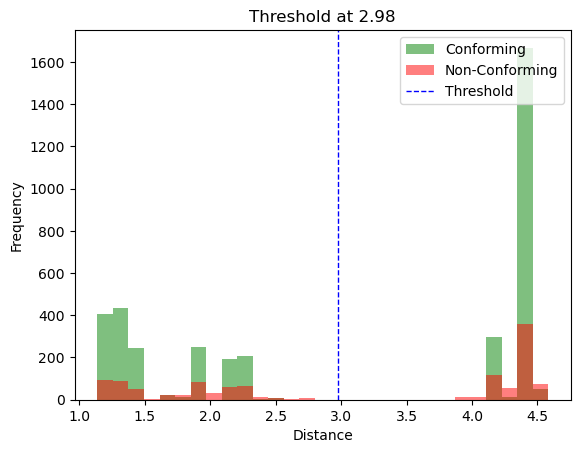

In [18]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Filter the DataFrame into conforming and non-conforming subsets
conforming_distances = results[results['conform'] == 1]['distance']
non_conforming_distances = results[results['conform'] == 0]['distance']

# Determine common bin edges
min_distance = min(results['distance'])
max_distance = max(results['distance'])
bin_edges = np.linspace(min_distance, max_distance, num=30)

# Combine the data and reshape for k-means
all_distances = results['distance']
all_distances = np.array(all_distances)
all_distances_reshaped = all_distances.reshape(-1, 1)

# Apply k-means clustering
kmeans = KMeans(n_clusters=2, random_state=0).fit(all_distances_reshaped)
kmeans_labels = kmeans.labels_

# Find the threshold as the average of the two cluster centers
threshold_value = np.mean(kmeans.cluster_centers_)

# Plot histograms and the threshold
plt.hist(conforming_distances, bins=bin_edges, alpha=0.5, label='Conforming', color='green')
plt.hist(non_conforming_distances, bins=bin_edges, alpha=0.5, label='Non-Conforming', color='red')
plt.axvline(threshold_value, color='blue', linestyle='dashed', linewidth=1, label='Threshold')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title(f'Threshold at {threshold_value:.2f}')

plt.savefig('Model_A_Threshold.png', dpi=300, bbox_inches='tight')

plt.show()

In [19]:
true_positive = np.sum(results[results['conform'] == 1]['distance'] < threshold_value)
true_negative = np.sum(results[results['conform'] == 0]['distance'] > threshold_value)
false_positive = np.sum(results[results['conform'] == 0]['distance'] < threshold_value)
false_negative = np.sum(results[results['conform'] == 1]['distance'] > threshold_value)

In [20]:
# Calculate accuracy
accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
print(f"Accuracy: {accuracy:.3f}")

Accuracy: 0.483


In [21]:
# Calculate f1

precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)

f1 = 2 * ((precision * recall) / (precision + recall))
print(f"F1: {f1:.3f}")

F1: 0.580


# Dev (Non Conform Traces)

In [22]:
# Calculate precision
precision = true_negative / (true_negative + false_negative)
print(f"Precision: {precision:.3f}")

Precision: 0.237


In [23]:
# Calculate recall
recall = true_negative / (true_negative + false_positive)
print(f"Recall: {recall:.3f}")

Recall: 0.530


# No Dev (Conform Traces)

In [24]:
# Calculate precision
precision = true_positive / (true_positive + false_positive)
print(f"Precision: {precision:.3f}")

Precision: 0.762


In [25]:
# Calculate recall
recall = true_positive / (true_positive + false_negative)
print(f"Recall: {recall:.3f}")

Recall: 0.468


# AUC_ROC

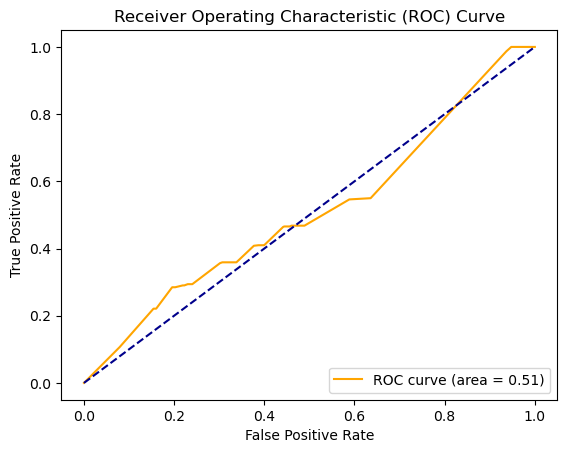

ROC AUC: 0.508


In [26]:
# UPDATED

import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Assuming 'results' is your DataFrame and 'distance' is the score to predict conformity

# Inverting the 'distance' scores because higher scores indicate non-conformity
# We invert the scores for ROC AUC calculation because roc_auc_score expects higher values
# to indicate higher likelihood of the positive class
inverted_scores = 1 - results['distance']

# Calculate the ROC curve and AUC using inverted scores
fpr, tpr, thresholds = roc_curve(results['conform'], inverted_scores, pos_label=1)
roc_auc = roc_auc_score(results['conform'], inverted_scores)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='orange', label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Print the AUC
print(f"ROC AUC: {roc_auc:.3f}")

# Deviations

### a) closest Trace

In [27]:
# INPUT TRACE 1



import pm4py
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.bpmn.importer import importer as bpmn_importer
from pm4py.algo.conformance.alignments.petri_net import algorithm as alignments_petri

# 2. Import the given BPMN model
bpmn_graph = bpmn_importer.apply("../../data/input_traces/large_input1.bpmn")

# 3. Convert the BPMN to a Petri net
net, initial_marking, final_marking = pm4py.convert_to_petri_net(bpmn_graph)

aligned_input_trace1 = generate_alignments_adjusted_tracecost_pkl(log, net, initial_marking, final_marking)

# Initialize an array to capture fitness values
fitness_trace_1 = []

# 5. Iterate through each alignment and capture fitness values
for alignment in aligned_input_trace1:
    fitness_trace_1.append(alignment['fitness'])

aligning log, completed variants ::   0%|          | 0/1145 [00:00<?, ?it/s]

In [28]:
# INPUT TRACE 2



import pm4py
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.bpmn.importer import importer as bpmn_importer
from pm4py.algo.conformance.alignments.petri_net import algorithm as alignments_petri

# 2. Import the given BPMN model
bpmn_graph = bpmn_importer.apply("../../data/input_traces/large_trace2.bpmn")

# 3. Convert the BPMN to a Petri net
net, initial_marking, final_marking = pm4py.convert_to_petri_net(bpmn_graph)

aligned_input_trace2 = generate_alignments_adjusted_tracecost_pkl(log, net, initial_marking, final_marking)

# Initialize an array to capture fitness values
fitness_trace_2 = []

# 5. Iterate through each alignment and capture fitness values
for alignment in aligned_input_trace2:
    fitness_trace_2.append(alignment['fitness'])

aligning log, completed variants ::   0%|          | 0/1145 [00:00<?, ?it/s]

In [29]:
# INPUT TRACE 3



import pm4py
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.bpmn.importer import importer as bpmn_importer
from pm4py.algo.conformance.alignments.petri_net import algorithm as alignments_petri

# 2. Import the given BPMN model
bpmn_graph = bpmn_importer.apply("../../data/input_traces/large_trace3.bpmn")

# 3. Convert the BPMN to a Petri net
net, initial_marking, final_marking = pm4py.convert_to_petri_net(bpmn_graph)

aligned_input_trace3 = generate_alignments_adjusted_tracecost_pkl(log, net, initial_marking, final_marking)

# Initialize an array to capture fitness values
fitness_trace_3 = []

# 5. Iterate through each alignment and capture fitness values
for alignment in aligned_input_trace3:
    fitness_trace_3.append(alignment['fitness'])

aligning log, completed variants ::   0%|          | 0/1145 [00:00<?, ?it/s]

In [30]:
# Create a dictionary with the lists
data = {
    'Trace 1': fitness_trace_1,
    'Trace 2': fitness_trace_2,
    'Trace 3': fitness_trace_3
}

# Create the DataFrame
fitness = pd.DataFrame(data)

In [31]:
# Function to determine the trace with the highest value
def highest_trace(row):
    if row['Trace 1'] == max(row):
        return 'trace_1'
    elif row['Trace 2'] == max(row):
        return 'trace_2'
    else:
        return 'trace_3'

# Add a new column using the highest_trace function
fitness['Closest Trace'] = fitness.apply(highest_trace, axis=1)

In [32]:
fitness

,Trace 1,Trace 2,Trace 3,Closest Trace
0,0.560976,1.000,0.552632,trace_2
1,0.926829,0.550,0.526316,trace_1
2,0.560976,0.875,0.552632,trace_2
3,0.926829,0.550,0.526316,trace_1
4,0.926829,0.550,0.526316,trace_1
...,...,...,...,...
4995,0.560976,1.000,0.552632,trace_2
4996,0.560976,0.875,0.552632,trace_2
4997,0.926829,0.550,0.526316,trace_1
4998,0.975610,0.550,0.526316,trace_1


### b) identify deviations

In [33]:
def extract_log_model_moves(aligned_traces):
    log_model_moves = []
    for trace_alignment in aligned_traces:
        log_moves = sum(1 for step in trace_alignment['alignment'] if step[0] == '>>')
        model_moves = sum(1 for step in trace_alignment['alignment'] if step[1] == '>>')
        log_model_moves.append({'log_moves': log_moves, 'model_moves': model_moves})
    return log_model_moves

- **Ground Truth: log and model moves:** 

In [47]:
# Extract log and model moves
log_model_moves_ground_truth = extract_log_model_moves(aligned_traces)

# Create a dataframe
log_model_moves_ground_truth = pd.DataFrame(log_model_moves_ground_truth)

log_model_moves_ground_truth.head(20)

,log_moves,model_moves
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,2,2


- **Predicted: log and model moves:** 

In [35]:
log_model_moves_predicted1 = extract_log_model_moves(aligned_input_trace1)
log_model_moves_predicted2 = extract_log_model_moves(aligned_input_trace2)
log_model_moves_predicted3 = extract_log_model_moves(aligned_input_trace3)

log_model_moves_predicted1 = pd.DataFrame(log_model_moves_predicted1)
log_model_moves_predicted2 = pd.DataFrame(log_model_moves_predicted2)
log_model_moves_predicted3 = pd.DataFrame(log_model_moves_predicted3)

In [36]:
# Initialize an empty dataframe for the result
result_df = pd.DataFrame(columns=['log_moves', 'model_moves'])

# Iterate over each row to find the minimum sum of log_moves and model_moves
for i in range(len(log_model_moves_predicted1)):
    sum1 = log_model_moves_predicted1.iloc[i]['log_moves'] + log_model_moves_predicted1.iloc[i]['model_moves']
    sum2 = log_model_moves_predicted2.iloc[i]['log_moves'] + log_model_moves_predicted2.iloc[i]['model_moves']
    sum3 = log_model_moves_predicted3.iloc[i]['log_moves'] + log_model_moves_predicted3.iloc[i]['model_moves']
    
    if sum1 <= sum2 and sum1 <= sum3:
        result_df = result_df.append(log_model_moves_predicted1.iloc[i], ignore_index=True)
    elif sum2 <= sum1 and sum2 <= sum3:
        result_df = result_df.append(log_model_moves_predicted2.iloc[i], ignore_index=True)
    else:
        result_df = result_df.append(log_model_moves_predicted3.iloc[i], ignore_index=True)

/var/folders/s_/ch_w_j2d0sqf6dbdc0_224m40000gq/T/ipykernel_1237/4133058459.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(log_model_moves_predicted2.iloc[i], ignore_index=True)
/var/folders/s_/ch_w_j2d0sqf6dbdc0_224m40000gq/T/ipykernel_1237/4133058459.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(log_model_moves_predicted1.iloc[i], ignore_index=True)
/var/folders/s_/ch_w_j2d0sqf6dbdc0_224m40000gq/T/ipykernel_1237/4133058459.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(log_model_moves_predicted2.iloc[i], ignore_index=True)
/var/folders/s_/ch_w_j2d0sqf6dbdc0_224m40000gq/T/ipykernel_1237/4133058459.py:11: FutureWarning: 

In [37]:
log_model_moves_ground_truth.head(10)

,log_moves,model_moves
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,2,2


In [38]:
result_df.head(10)

,log_moves,model_moves
0,0,0
1,2,2
2,3,3
3,2,2
4,2,2
5,2,2
6,3,3
7,0,0
8,0,0
9,5,5


# Visualization

In [39]:
aligned_traces[19]

{'alignment': [('Activity A', 'Activity A'),
  ('Activity C', 'Activity C'),
  ('Activity D', 'Activity D'),
  ('Activity E', 'Activity E'),
  ('Activity H', 'Activity H'),
  ('Activity F', 'Activity F'),
  ('Random activity 5', '>>'),
  ('Activity I', 'Activity I'),
  ('Activity O', 'Activity O'),
  ('Activity P', 'Activity P'),
  ('Activity J', 'Activity J'),
  ('Activity B', 'Activity B')],
 'cost': 9999.4,
 'visited_states': 12,
 'queued_states': 40,
 'traversed_arcs': 40,
 'lp_solved': 1,
 'fitness': 1.0,
 'bwc': 399956.5}

In [43]:
fitness['Closest Trace'][19]

'trace_2'

In [46]:
aligned_input_trace2[19]

{'alignment': [('Activity A', 'Activity A'),
  ('Activity C', 'Activity C'),
  ('Activity D', 'Activity D'),
  ('Activity E', 'Activity E'),
  ('>>', 'Activity G'),
  ('Activity H', '>>'),
  ('Activity F', 'Activity F'),
  ('Random activity 5', '>>'),
  ('Activity I', 'Activity I'),
  ('Activity O', 'Activity O'),
  ('Activity P', 'Activity P'),
  ('Activity J', 'Activity J'),
  ('Activity B', 'Activity B')],
 'cost': 29999.0,
 'visited_states': 13,
 'queued_states': 36,
 'traversed_arcs': 36,
 'lp_solved': 4,
 'fitness': 0.95,
 'bwc': 409956.5}

In [40]:
results['trace'][19]

['Activity A',
 'Activity C',
 'Activity D',
 'Activity E',
 'Activity H',
 'Activity F',
 'Random activity 5',
 'Activity I',
 'Activity O',
 'Activity P',
 'Activity J',
 'Activity B']